In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import copy

In [27]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [28]:
df = pd.read_csv("data/mit_bih.csv", index_col=0)
df.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179
0,0.580723,0.579518,0.581928,0.580723,0.584337,0.581928,0.581928,0.580723,0.580723,0.584337,...,0.553012,0.555422,0.554217,0.551807,0.553012,0.549398,0.550602,0.550602,0.553012,0.550602
1,0.574699,0.571084,0.571084,0.568675,0.569880,0.572289,0.574699,0.572289,0.572289,0.572289,...,0.557831,0.554217,0.556627,0.556627,0.555422,0.554217,0.553012,0.553012,0.551807,0.554217
2,0.563855,0.561446,0.568675,0.567470,0.568675,0.567470,0.567470,0.565060,0.567470,0.571084,...,0.566265,0.565060,0.563855,0.561446,0.560241,0.560241,0.563855,0.566265,0.561446,0.562651
3,0.571084,0.571084,0.569880,0.568675,0.571084,0.574699,0.574699,0.573494,0.573494,0.572289,...,0.556627,0.551807,0.551807,0.551807,0.553012,0.551807,0.545783,0.546988,0.545783,0.549398
4,0.572289,0.572289,0.572289,0.575904,0.575904,0.575904,0.571084,0.569880,0.572289,0.574699,...,0.557831,0.559036,0.559036,0.556627,0.555422,0.551807,0.551807,0.555422,0.555422,0.553012


In [29]:
df.iloc[0]

t_0      0.580723
t_1      0.579518
t_2      0.581928
t_3      0.580723
t_4      0.584337
           ...   
t_175    0.549398
t_176    0.550602
t_177    0.550602
t_178    0.553012
t_179    0.550602
Name: 0, Length: 180, dtype: float64

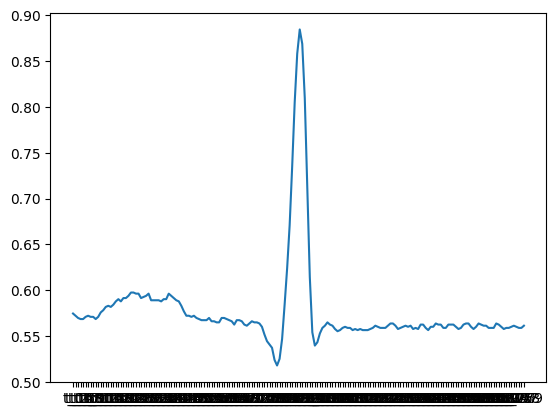

In [31]:
plt.plot(df.iloc[234,:])

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [34]:
dataset,seq_len, n_feat = create_dataset(df)

In [48]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(seq_len, n_feat, device, 128)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [49]:
model, history = train_model(
  model, 
  train_dataset=dataset[0:80], 
  val_dataset=dataset[80:100], 
  n_epochs=10,
  lr=3e-3
)

Epoch 1: train loss 12.687272518873215 val loss 5.02055811882019
Epoch 2: train loss 6.273537594079971 val loss 6.257660508155823
Epoch 3: train loss 5.586614507436752 val loss 4.720851039886474
Epoch 4: train loss 5.334838458895684 val loss 5.614840579032898
Epoch 5: train loss 5.290859305858612 val loss 6.404283833503723
Epoch 6: train loss 4.973880338668823 val loss 5.163211596012116
Epoch 7: train loss 5.1249655216932295 val loss 6.389479184150696
Epoch 8: train loss 4.898167678713799 val loss 6.490676856040954
Epoch 9: train loss 5.140059849619865 val loss 5.30163459777832
Epoch 10: train loss 5.081345176696777 val loss 4.6327358961105345


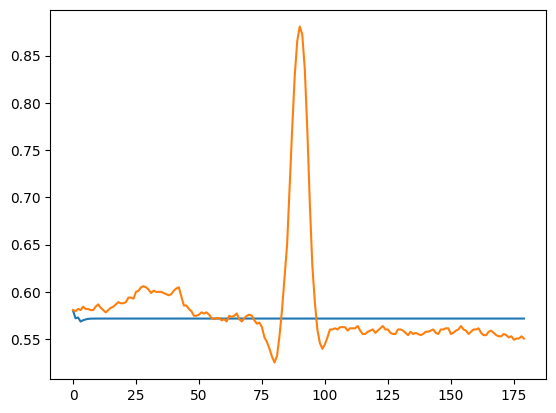

In [50]:
plt.plot(model(dataset[0]).detach().numpy().squeeze())
plt.plot(dataset[0].detach().numpy().squeeze())